### EDA- Censos Argentina- VAriables Viviendas e Indice de MAsculinidad

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [41]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
df=df.sort_values('nam')
if df is not None:
    print(df)
df.drop('Superficie', axis=1, inplace=True)
dataframe_to_latex(df.head(10), 'censosamba.tex')

    # Example usage:
# # Assuming 'df' is your DataFrame
# dataframe_to_image(df.head(), 'output', 'svg')  # Save as SVG image
# dataframe_to_image(df.head(), 'output', 'jpeg') # Save as JPEG image



                nam cod_depto  anio       pob       var       muj   vivpart  \
35  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
33  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
32  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
34  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
..              ...       ...   ...       ...       ...       ...       ...   
75  Tres de Febrero     06840  1991  349376.0  167417.0  181959.0       NaN   
6     Vicente López     06861  2001  274082.0  127238.0  146844.0  108947.0   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
7     Vicente López     06861  1991  289505.0  135426.0  154079.0       NaN   
5     Vicente López     06861  2010  269420.0  125792.0  143628.0  114747.0   

    vivtotal  Superficie     sup ind_masc dens_pob 

In [12]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 35 to 5
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nam        96 non-null     object 
 1   cod_depto  96 non-null     object 
 2   anio       96 non-null     object 
 3   pob        90 non-null     float64
 4   var        90 non-null     float64
 5   muj        90 non-null     float64
 6   vivpart    72 non-null     float64
 7   vivtotal   72 non-null     float64
 8   sup        96 non-null     object 
 9   ind_masc   90 non-null     object 
 10  dens_pob   90 non-null     object 
dtypes: float64(5), object(6)
memory usage: 9.0+ KB


nam           0
cod_depto     0
anio          0
pob           6
var           6
muj           6
vivpart      24
vivtotal     24
sup           0
ind_masc      6
dens_pob      6
dtype: int64

### Colectivas vs Particulares %  

In [23]:
# Sort By anio
df = df.sort_values(by='anio')
# Step 1: Calculate the percentage of vivpart out of vivtotal
df['%vivpart'] = ((df['vivpart'] / (df['vivpart'] + df['vivtotal'])) * 100).round(2)

print(df.tail(10))

                   nam cod_depto  anio       pob       var       muj  \
24               Tigre     06805  2022  447785.0  215056.0  228822.0   
40  Esteban Echeverría     06260  2022  339030.0  163974.0  174468.0   
60  General San Martín     06371  2022  450335.0  213300.0  233690.0   
88     Lomas de Zamora     06490  2022  694330.0  332115.0  359231.0   
32     Almirante Brown     06028  2022  585852.0  281842.0  301779.0   
20        San Fernando     06749  2022  172524.0   81719.0   89879.0   
44          San Miguel     06760  2022  326215.0  157244.0  168569.0   
68           Ituzaingó     06410  2022  179788.0   84855.0   92708.0   
92          Avellaneda     06035  2022  370939.0  174572.0  194911.0   
52               Morón     06568  2022  334178.0  156891.0  175565.0   

     vivpart  vivtotal      sup ind_masc dens_pob  %vivpart  
24  152750.0      54.0   525.28     94.0   852.47     99.96  
40  109969.0      40.0   148.12     94.0  2288.89     99.96  
60  175969.0     113.

In [9]:
# ## NAN VALUES
# nan_values = df.isna().sum()
# print(nan_values)

# ## Fill NAN values with none
# df_filled = df.fillna(0)     ## Specific columm -->##{'pob': 0}
# nan_values = df_filled.isna().sum()
# print(nan_values)
# df=df_filled
# ## Claramente el año 1991 no tenemos esta info. Se desprecian estos datos

nam                           0
cod_depto                     0
anio                          0
pob                           0
var                           0
muj                           0
vivpart                       0
vivtotal                      0
sup                           0
ind_masc                      0
dens_pob                      0
%_vivpart_of_vivtotal        24
%_vivtotal_of_viv            24
vivtotal_to_vivpart_ratio    24
dtype: int64
nam                          0
cod_depto                    0
anio                         0
pob                          0
var                          0
muj                          0
vivpart                      0
vivtotal                     0
sup                          0
ind_masc                     0
dens_pob                     0
%_vivpart_of_vivtotal        0
%_vivtotal_of_viv            0
vivtotal_to_vivpart_ratio    0
dtype: int64


C:\Users\Fer\AppData\Local\Temp\ipykernel_14508\2322676269.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='anio', y='%vivpart', palette='muted')
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


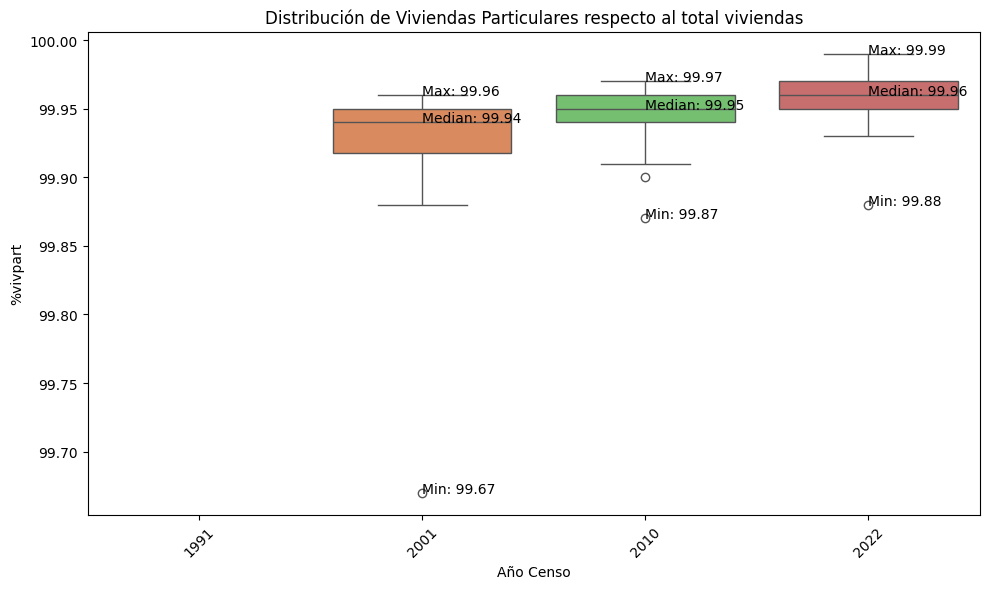

In [35]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='anio', y='%vivpart', palette='muted')
plt.title('Distribución de Viviendas Particulares respecto Total Viviendas')
plt.xlabel('Año Censo')
plt.ylabel('%vivpart')
plt.xticks(rotation=45)
plt.tight_layout()

# Add text annotations for boxplot metrics
boxplot_stats = df.groupby('anio')['%vivpart'].describe()
for i in range(len(boxplot_stats)):
    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], '50%'], f"Median: {boxplot_stats.loc[boxplot_stats.index[i], '50%']:.2f}")
    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], 'min'], f"Min: {boxplot_stats.loc[boxplot_stats.index[i], 'min']:.2f}")
    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], 'max'], f"Max: {boxplot_stats.loc[boxplot_stats.index[i], 'max']:.2f}")

plt.show()

### Indice MAsculinidad

C:\Users\Fer\AppData\Local\Temp\ipykernel_14508\873193448.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='anio', y='ind_masc', palette='muted')


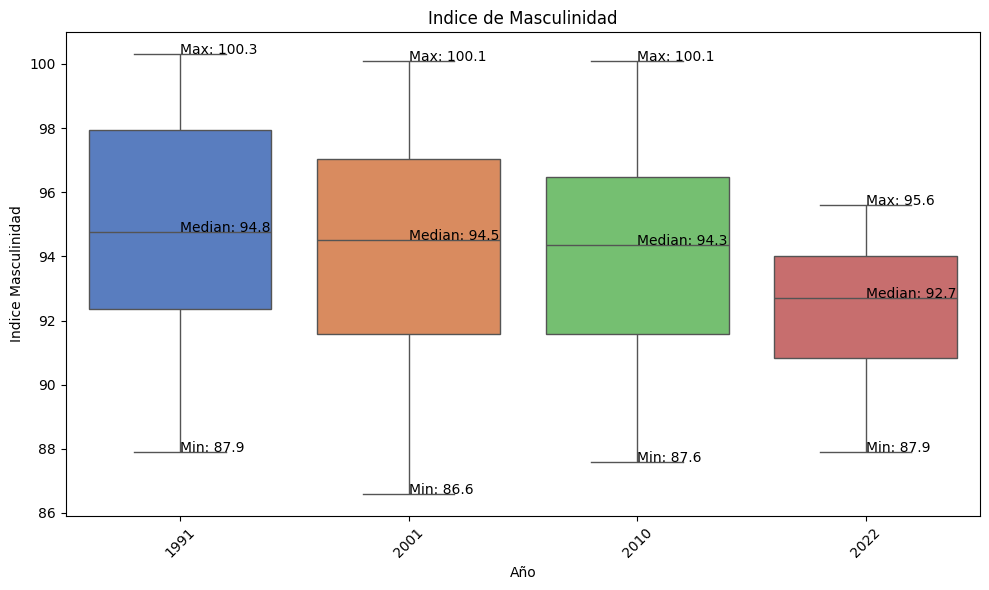

      count       mean       std   min     25%    50%     75%    max
anio                                                                
1991   18.0  95.027778  3.438503  87.9  92.350  94.75  97.925  100.3
2001   24.0  94.295833  3.598004  86.6  91.575  94.50  97.025  100.1
2010   24.0  94.279167  3.323432  87.6  91.575  94.35  96.475  100.1
2022   24.0  92.408333  2.219463  87.9  90.825  92.70  94.025   95.6


In [75]:
df = df.sort_values(by='anio')

# Convert 'ind_masc' and 'dens_pob' columns to float
df['ind_masc'] = df['ind_masc'].astype(float)
df['dens_pob'] = df['dens_pob'].astype(float)

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='anio', y='ind_masc', palette='muted')
plt.title('Indice de Masculinidad')
plt.xlabel('Año')
plt.ylabel('Indice Masculinidad')
plt.xticks(rotation=45)
plt.tight_layout()

# Add text annotations for boxplot metrics
boxplot_stats = df.groupby('anio')['ind_masc'].describe()
for i in range(len(boxplot_stats)):

    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], '50%'], f"Median: {boxplot_stats.loc[boxplot_stats.index[i], '50%']:.1f}")
  
    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], 'min'], f"Min: {boxplot_stats.loc[boxplot_stats.index[i], 'min']:.1f}")
    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], 'max'], f"Max: {boxplot_stats.loc[boxplot_stats.index[i], 'max']:.1f}")

plt.show()

print(boxplot_stats)

### DENS POBLACION

C:\Users\Fer\AppData\Local\Temp\ipykernel_14508\1035729327.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='anio', y='dens_pob', palette='muted')


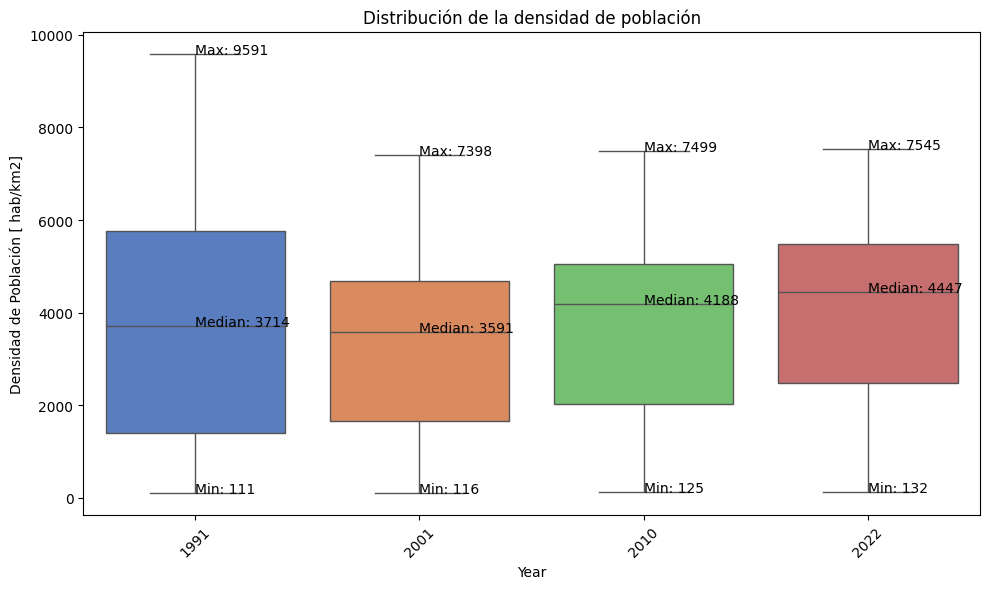

In [73]:

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='anio', y='dens_pob', palette='muted')
plt.title('Distribución de la densidad de población')
plt.xlabel('Year')
plt.ylabel('Densidad de Población [ hab/km2]')
plt.xticks(rotation=45)
plt.tight_layout()

# Add text annotations for boxplot metrics
boxplot_stats = df.groupby('anio')['dens_pob'].describe()
for i in range(len(boxplot_stats)):

    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], '50%'], f"Median: {boxplot_stats.loc[boxplot_stats.index[i], '50%']:.0f}")
  
    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], 'min'], f"Min: {boxplot_stats.loc[boxplot_stats.index[i], 'min']:.0f}")
    plt.text(i, boxplot_stats.loc[boxplot_stats.index[i], 'max'], f"Max: {boxplot_stats.loc[boxplot_stats.index[i], 'max']:.0f}")

plt.show()

C:\Users\Fer\AppData\Local\Temp\ipykernel_14508\1666248853.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='anio', y='ind_masc', ci=None, color='darkgreen')


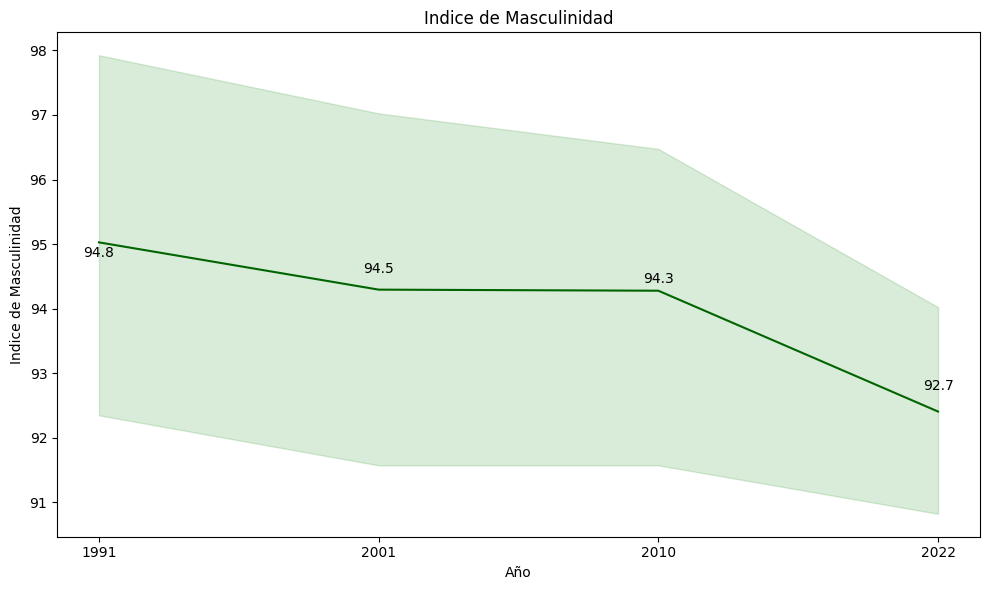

In [68]:
### TENDENCIA
# Calculate quartiles for 'ind_masc' over 'anio'
quartiles = df.groupby('anio')['ind_masc'].quantile([0.25, 0.5, 0.75]).unstack()

# Plot the line chart with quartile shading
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='anio', y='ind_masc', ci=None, color='darkgreen')
plt.fill_between(quartiles.index, quartiles[0.25], quartiles[0.75], color='green', alpha=0.15)
# Add value annotations to the main line
for i in range(len(quartiles)):
    plt.text(quartiles.index[i], quartiles.iloc[i, 1], f'{quartiles.iloc[i, 1]:.1f}', 
             horizontalalignment='center', verticalalignment='bottom')
plt.title('Indice de Masculinidad')
plt.xlabel('Año')
plt.ylabel('Indice de Masculinidad')
plt.tight_layout()
plt.show()

C:\Users\Fer\AppData\Local\Temp\ipykernel_14508\2022957464.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='anio', y='dens_pob', ci=None, color='darkblue')


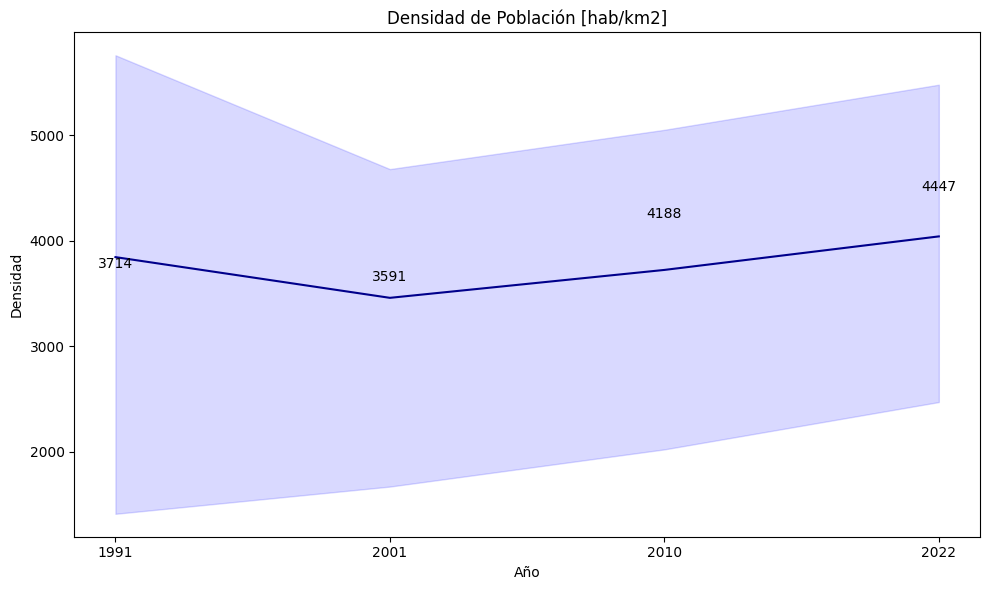

In [65]:
### TENDENCIA DENSIDAD
# Calculate quartiles for 'ind_masc' over 'anio'
quartiles = df.groupby('anio')['dens_pob'].quantile([0.25, 0.5, 0.75]).unstack()

# Plot the line chart with quartile shading
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='anio', y='dens_pob', ci=None, color='darkblue')
plt.fill_between(quartiles.index, quartiles[0.25], quartiles[0.75], color='blue', alpha=0.15)
# Add value annotations to the main line
for i in range(len(quartiles)):
    plt.text(quartiles.index[i], quartiles.iloc[i, 1], f'{quartiles.iloc[i, 1]:.0f}', 
             horizontalalignment='center', verticalalignment='bottom')
plt.title('Densidad de Población [hab/km2]')
plt.xlabel('Año')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()

C:\Users\Fer\AppData\Local\Temp\ipykernel_14508\264538797.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='anio', y='%vivpart', ci=None, color='darkorange')
posx and posy should be finite values
posx and posy should be finite values


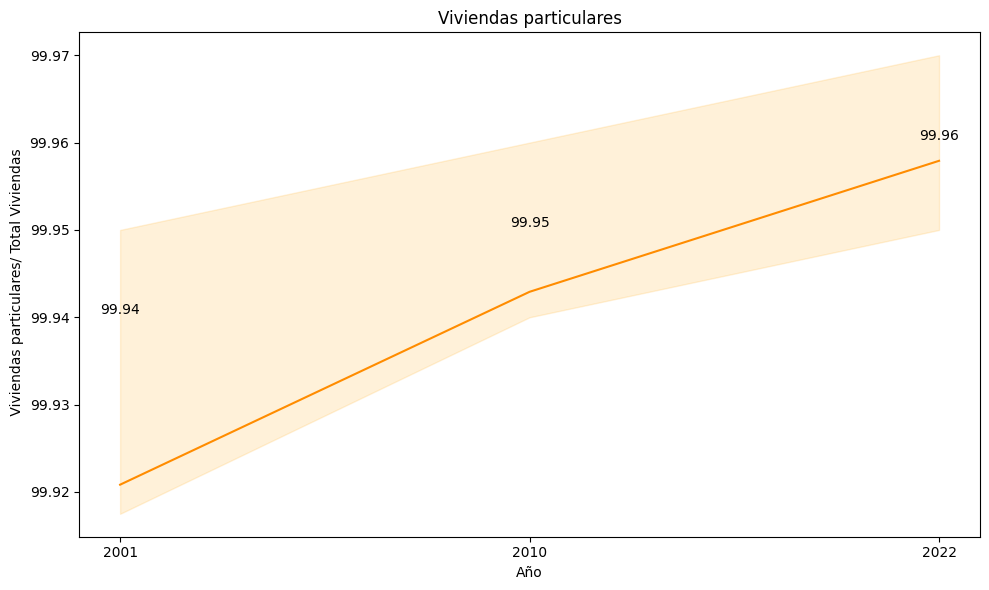

In [72]:
### TENDENCIA VIVIENDAS PARTICULARES
df['%vivpart'] = ((df['vivpart'] / (df['vivpart'] + df['vivtotal'])) * 100).round(2)
# Calculate quartiles for 'ind_masc' over 'anio'
quartiles = df.groupby('anio')['%vivpart'].quantile([0.25, 0.5, 0.75]).unstack()

# Plot the line chart with quartile shading
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='anio', y='%vivpart', ci=None, color='darkorange')
plt.fill_between(quartiles.index, quartiles[0.25], quartiles[0.75], color='orange', alpha=0.15)
# Add value annotations to the main line
for i in range(len(quartiles)):
    plt.text(quartiles.index[i], quartiles.iloc[i, 1], f'{quartiles.iloc[i, 1]:.2f}', 
             horizontalalignment='center', verticalalignment='bottom')
plt.title('Viviendas particulares')
plt.xlabel('Año')
plt.ylabel(' Viviendas particulares/ Total Viviendas')
plt.tight_layout()
plt.show()